# Comparing Multi-Agent System to a Single-Model Baseline for Code Generation

This notebook presents a comparative study evaluating the performance of a multi-agent system for automated code generation against a single large language model (LLM) baseline. The multi-agent system, designed with specialized agents for tasks such as preprocessing, retrieval, planning, coding, and debugging, aims to tackle complex coding challenges more effectively than a monolithic single-model approach.


## Setup

In [5]:
import os
import sys
import dotenv
import json
from loguru import logger

# Append the models path in order to import the models
PROJECT_ROOT = os.path.join(os.getcwd(), 'src/')
print(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

# Load env variables
dotenv.load_dotenv()

# Set log level INFO
logger.remove()
logger.add(sys.stderr, level="INFO")

/home/twanh/workspace/thesis/thesis-advent-of-agents/src/


1

In [30]:
# Import models from the system
from models.base_model import BaseLanguageModel
from models.gemini_model import GeminiLanguageModel
from models.openai_model import OpenAILanguageModel
from models.deepseek_model import DeepseekLanguageModel

### Load puzzles and input/outputs

In [31]:
# Get the correct paths
test_data_folder = os.path.join(PROJECT_ROOT, '..', 'experiments', 'test_data')
puzzles_folder = os.path.join(test_data_folder, 'puzzles/')
input_output_file = os.path.join(test_data_folder, 'answers2024.json')
puzzle_files = [os.path.join(puzzles_folder, f) for f in os.listdir(puzzles_folder) if os.path.isfile(os.path.join(puzzles_folder, f))]

In [32]:
# Create a datastructure were we can get by day
json_data = {}
with open(input_output_file, 'r') as f:
    json_data = {item['day']: item for item in json.load(f)}

puzzle_data = []
for file_path in puzzle_files:
    # Get the day of the puzzle file
    file_name = os.path.basename(file_path)
    day_str = file_name.split('_')[-1].split('.')[0]
    day = int(day_str)

    if day in json_data:
        with open(file_path, 'r') as f:
            puzzle_description = f.read()

        puzzle_info = {
            "year": json_data[day]['year'],
            "day": day,
            "description": puzzle_description,
            "input": json_data[day]['input'],
            "expected_output": json_data[day]['part1']
        }

        puzzle_data.append(puzzle_info)

# Sort by day
puzzle_data.sort(key=lambda x: x['day'])
print(len(puzzle_data)) # should be 25

25


### Model Configurations

Create the configurations for the baseline and the system to use. Since the advent of agents system can use multiple models for each agent, the model used for each agent will be the same as the single model used for the baseline.

The models that will be tested are:

<!-- TODO: Update model list -->
- Gemini
- OpenAI

In [44]:
from main import _get_model

models_to_test = ('gemini-2.0-flash', 'gemini-2.5-pro-preview-05-06' ,'gpt-4.1-mini', 'o3-mini')

configs = [_get_model(model) for model in models_to_test]
print(configs)

[<models.gemini_model.GeminiLanguageModel object at 0x7016b3db2210>, <models.gemini_model.GeminiLanguageModel object at 0x7016b3c17680>, <models.openai_model.OpenAILanguageModel object at 0x7016b3c17770>, <models.openai_model.OpenAILanguageModel object at 0x7016b3d68ce0>]


## Baseline

### Baseline prompt

The prompt is based on the prompt the advent of agents system uses. However the baseline has no acess to the information the other agents provide. So there is only the `full_description` that provides the model with the puzzle. 
The steps in the prompt are the same expect the first step is removed, which was to analyze the generated plan.

In [36]:
BASELINE_PROMPT = """
# Advent of Code Implementation Agent

You are an expert coding agent specializing in implementing solutions for Advent of Code puzzles.
Your task is to convert a detailed solution plan into clean, efficient, and correct Python code that solves the given problem.
You excel at translating algorithmic plans into precise implementations.


It will be provided as the following JSON

```json
{{
    "full_description": "The full description of the problem (string)",
}}
```

## YOUR RESPONSIBILITIES

Your primary goal is to produce a complete, correct, and efficient Python implementation that:

1. Correctly solves both the provided examples and will work for the actual puzzle input
2. Follows good software engineering practices
3. Includes appropriate comments and documentation
4. Handles edge cases and potential errors
5. Is executable via command line as: `python3 [program].py [puzzleinputfile]`

## IMPLEMENTATION PROCESS

Follow these steps meticulously:

-----------------------------------------
STEP 1. Design Your Code Structure
-----------------------------------------

- Create a clear, modular structure with well-named functions matching the plan's major steps
- Define appropriate data structures with explicit type hints
- Plan your function signatures and interfaces before implementation
- Use the keywords and underlying concepts to think about what algoritms to use to solve the problems.

-----------------------------------------
STEP 2. Implement Core Logic
-----------------------------------------

- Write robust implementations of all algorithms described in the plan
- Include detailed comments explaining complex logic
- Follow Python best practices (PEP 8, appropriate naming conventions)
- Use type hints throughout your code


-----------------------------------------
STEP 3. Handle Edge Cases Explicitly
-----------------------------------------

- Add specific code to handle all edge cases mentioned in the plan
- Anticipate and handle additional edge cases common in Advent of Code:
  - Empty input
  - Boundary conditions (min/max values)
- Use the test cases to reason about your code and make sure it would solve the test cases correctly

----------------------------------------
STEP 4. Test Against Examples
----------------------------------------

- Include code that runs and validates against all provided examples
- Add assertions to verify intermediate results match expected values
- Print debugging information that would help diagnose issues to STDERR
    - STDOUT can only be used to print the final result.

----------------------------------------
STEP 5. Optimize If Necessary
-----------------------------------------

- Review your solution for performance bottlenecks
- Apply optimizations where appropriate, explaining your choices
- Ensure the solution will scale to handle the full problem input

-----------------------------------------
STEP 6. Finalize Solution
-----------------------------------------

- Ensure your code has a clear entry point (typically a `main()` function)
- Include code to read from the puzzle input file specified as a command-line argument
- Make sure that your code follows the proper structure as documented (example code template) below.
- Add a brief summary comment at the top explaining the approach
- Verify all functions have appropriate docstrings


-----------------------------------------
OUTPUT FORMAT
-----------------------------------------
Your response must be a valid JSON object with the following structure:

The generated code should be provided as the value of the code key in the JSON object. Ensure that the code is properly escaped to be a valid JSON string. This means that any double quotes within the code should be escaped with a backslash (\"), and newlines should be represented as \\n

```json
{{
  "code": "Complete Python code as a string with all necessary formatting. MAKE SURE THAT THIS IS VALID JSON"
}}
```


## EXAMPLE CODE TEMPLATE

```python
\"\"\"
Advent of Code [Year] Day [Number]: [Title]
Solution implementation based on the provided plan.

Usage: python3 solution.py [input_file]
\"\"\"
from typing import List, Dict, Tuple, Set, Optional
import sys
from collections import defaultdict, deque
import re
# Import other necessary libraries

def parse_input(input_file: str) -> [appropriate_return_type]:
    "\"\"Parse the puzzle input from file into appropriate data structures.

    Args:
        input_file: Path to the input file

    Returns:
        [Description of return value]
    \"\"\"
    with open(input_file, 'r') as f:
        # Process file content
        pass
    # Implementation...

def solve_part_one(parsed_data: [type]) -> [type]:
    \"\"\"Solve part one of the puzzle.

    Args:
        parsed_data: Processed input data

    Returns:
        Solution for part one
    \"\"\"
    # Implementation...

def main():
    # Check command line arguments
    if len(sys.argv) < 2:
        print("Usage: python3 solution.py [input_file]")
        return

    input_file = sys.argv[1]

    # Parse input
    parsed_data = parse_input(input_file)

    # Solve part one
    part_one_solution = solve_part_one(parsed_data)
    # ONLY PRINT THE RESULT, NO OTHER TEXT
    print(part_one_solution)

    # Test with examples (if available)
    # [Example testing code]

if __name__ == "__main__":
    main()
```

Remember to follow the plan closely while filling in implementation details that the planner may have omitted. Your goal is to bridge the gap between algorithmic description and working code.


-----------------------------------

Your input is:

{json_input}

"""

### Run baseline

In [37]:
from utils.utils import extract_json_from_markdown
from agents.debugging_agent import DebuggingAgent
from utils.util_types import TestCase

def run_and_test_baseline(puzzle: str, puzzle_input: str, expected_output: str, model: BaseLanguageModel) -> bool:

    # Create the prompts
    json_inp = json.dumps({'full_description': puzzle})
    prompt = BASELINE_PROMPT.format(json_input=json_inp)
    # Prompt the model
    resp = model.prompt(prompt)

    # Extract the solution
    try:
        code = json.loads(extract_json_from_markdown(resp)[0]).get('code')
    except json.JSONDecodeError:
        print("Failed because decode")
        # TODO: Add retrying?
        return False, "NO CODE"

    # Use debugging agent to test the final solution
    dba = DebuggingAgent(
        'debugging',
        model=model,
        expected_output=expected_output,
        puzzle_input=puzzle_input,
    )
    run_result = dba._run_test(
        code,
        TestCase(
            input_=puzzle_input,
            expected_output=expected_output,
        ),
    )

    return run_result.success, code


In [ ]:
# baseline_results = {}
# total = 0
# solved = 0
# # TODO: remove slice when running full tests
# for config in configs[:1]:
#     baseline_model = config['baseline']
#     baseline_results[baseline_model.model_name] = {}
#     print(f"Using model: {baseline_model.model_name}")
#     for puzzle in puzzle_data:
#         total += 1
#         print(f"Running day {puzzle['day']}")
#         success = run_and_test_baseline(
#             puzzle=puzzle['description'],
#             puzzle_input=puzzle['input'],
#             expected_output=str(puzzle['expected_output']),
#             model=baseline_model
#         )
#         baseline_results[baseline_model.model_name][puzzle['day']] = success
#         if success:
#             print("Solved!")
#             solved += 1
#         else:
#             print("Not solved")

# print(f"Solved: {solved}/{total}")

Using model: gemini-2.0-flash
Running day 1


2025-05-19 11:28:45.169 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:28:45.172 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:28:45.244 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1646452=1646452


Solved!
Running day 2


2025-05-19 11:28:49.242 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:28:49.245 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:28:49.364 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 524=524


Solved!
Running day 3
Failed because decode
Not solved
Running day 4


2025-05-19 11:28:58.379 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:28:58.380 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:28:58.481 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 2464=2464


Solved!
Running day 5


2025-05-19 11:29:03.091 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:03.095 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:03.263 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 11:29:03.267 | INFO     | agents.debugging_agent:_run_test:358 - Got: 5997, expected: 5391


Not solved
Running day 6
Failed because decode
Not solved
Running day 7
Failed because decode
Not solved
Running day 8
Failed because decode
Not solved
Running day 9


2025-05-19 11:29:23.402 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:23.406 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:28.590 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-19 11:29:28.591 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 11:29:28.592 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 6279058075753


Not solved
Running day 10


2025-05-19 11:29:33.808 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:33.810 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:33.894 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 459=459


Solved!
Running day 11


2025-05-19 11:29:37.910 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:37.913 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:38.215 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 193899=193899


Solved!
Running day 12


2025-05-19 11:29:44.255 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:44.260 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:44.486 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1449902=1449902


Solved!
Running day 13


2025-05-19 11:29:51.834 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:51.837 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:51.918 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 29517=29517


Solved!
Running day 14


2025-05-19 11:29:58.081 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:29:58.083 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:29:58.168 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 230461440=230461440


Solved!
Running day 15


2025-05-19 11:30:05.967 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:30:05.972 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:30:06.073 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 11:30:06.074 | INFO     | agents.debugging_agent:_run_test:358 - Got: 1453784, expected: 1478649


Not solved
Running day 16
Failed because decode
Not solved
Running day 17
Failed because decode
Not solved
Running day 18


2025-05-19 11:30:22.867 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:30:22.870 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:30:22.991 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 334=334


Solved!
Running day 19
Failed because decode
Not solved
Running day 20


2025-05-19 11:30:36.278 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:30:36.282 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:30:41.353 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-19 11:30:41.354 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 11:30:41.355 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 1415


Not solved
Running day 21
Failed because decode
Not solved
Running day 22


2025-05-19 11:30:52.069 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:30:52.073 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:30:53.665 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 13234715490=13234715490


Solved!
Running day 23


2025-05-19 11:30:58.704 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:30:58.707 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:31:03.738 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-19 11:31:03.739 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 11:31:03.740 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 1485


Not solved
Running day 24


2025-05-19 11:31:11.193 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:31:11.195 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:31:11.264 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 54715147844840=54715147844840


Solved!
Running day 25


2025-05-19 11:31:17.338 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:31:17.342 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:31:17.433 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 11:31:17.433 | INFO     | agents.debugging_agent:_run_test:358 - Got: 22250, expected: 2900


Not solved
Solved: 11/25


## System

In [38]:
from agents.base_agent import BaseAgent
from agents.coding_agent import CodingAgent
from agents.debugging_agent import DebuggingAgent
from agents.planning_agent import PlanningAgent
from agents.pre_processing_agent import PreProcessingAgent
from agents.retreival_agent import RetrievalAgent
from core.orchestrator import Orchestrator
from utils.util_types import AgentSettings
from core.state import MainState
from utils.util_types import Puzzle

In [39]:
def setup_system(model: BaseLanguageModel, puzzle_input: str, expected_output:str) -> Orchestrator:
    agents = (
        (
            PreProcessingAgent(
                'preprocess', model=model,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            RetrievalAgent(
                'retreival',
                model=model,
                connection_string=os.getenv('DB_CONNECTION_STRING') or '',
                openai_key=os.getenv('OPENAI_API_KEY') or '',
                # Use default weights
                weights=None,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            PlanningAgent(
                'planning',
                model=model,
                n_plans=3,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            CodingAgent('coding', model=model),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            DebuggingAgent(
                'debugging',
                model=model,
                expected_output=expected_output,
                puzzle_input=puzzle_input,
            ),
            AgentSettings(enabled=True, can_debug=True),
        ),
    )

    orchestrator = Orchestrator(agents, {})
    return orchestrator


In [40]:
def run__and_test_system(day: int, puzzle_desc: str, puzzle_input: str, expected_output: str, model: BaseLanguageModel) -> tuple[bool, str]:

    orch = setup_system(model, puzzle_input, expected_output)

    puzzle = Puzzle(
        description=puzzle_desc,
        solution=None,
        year = 2024,
        day=day,

    )

    state = MainState(puzzle=puzzle)
    ret_state = orch.solve_puzzle(state)

    return ret_state.is_solved, ret_state.final_code

In [ ]:
# system_results = {}
# system_total = 0
# system_solved = 0
# # TODO: remove slice when running full tests
# for config in configs[:1]:
#     baseline_model = config['baseline']
#     system_results[baseline_model.model_name] = {}
#     print(f"Using model: {baseline_model.model_name}")
#     for puzzle in puzzle_data:
#         total += 1
#         print(f"Running day {puzzle['day']}")
#         success = run__and_test_system(
#             puzzle['day'], puzzle['description'], puzzle['input'], puzzle['expected_output'], baseline_model
#         )
#         system_results[baseline_model.model_name][puzzle['day']] = success
#         if success:
#             solved += 1

# print(f"Solved: {solved}/{total}")

2025-05-19 11:50:19.448 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 11:50:19.454 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Using model: gemini-2.0-flash
Running day 1


2025-05-19 11:50:21.825 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:50:45.588 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:50:45.593 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:50:45.595 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 11:50:49.913 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem asks to calculate the total distance between two lists of integers. The lists are paired by sorting both lists and then calculating the absolute difference between the elements at the same index in the sorted lists. The total distance is the sum of these absolute differences.\n\n## 2. Data Structures\n*   `list`: Used to store the input integers for both lists.\n*   `list`: Used to store sorted versions of both input lists.\n

Solved puzzle
Running day 2


2025-05-19 11:51:09.283 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:51:23.365 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 7 column 722 (char 1266)')
2025-05-19 11:51:23.367 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 11:51:42.538 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:51:42.544 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:51:42.548 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 11:51:49.017 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nThe problem requires analyzing reports, each a list of numbers, and determining how many are "safe". A report is safe if the numbers are ei

Solved puzzle
Running day 3


2025-05-19 11:52:20.914 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:52:32.575 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-19 11:52:39.361 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:52:39.364 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:52:39.366 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 11:52:45.279 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires scanning a string for occurrences of the pattern `mul(X,Y)`, where X and Y are 1-3 digit numbers, multiplying X and Y for each valid instruction, and returning the sum of all products. The approach will use regular expressions to find valid mul instructions within the corrupted memory and 

Solved puzzle
Running day 4


2025-05-19 11:53:06.900 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:53:34.550 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:53:34.552 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:53:34.553 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 11:53:42.161 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe approach is to perform a brute-force search of the grid for the target word "XMAS" in all eight possible directions (horizontal, vertical, two diagonals, and their reversals). The code will iterate through each cell of the grid and check if the target word starts at that cell in any of the eight directions.\n\n## 2. Data Structures\n*   `grid (list of strings)`: A list of strings representing the word search grid. Each string is a ro

Solved puzzle
Running day 5


2025-05-19 11:54:12.703 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:54:49.768 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:54:49.772 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:54:49.774 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 11:54:58.258 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires validating a series of updates (lists of page numbers) against a set of ordering rules. The core idea is to parse the input, represent the ordering rules, and then, for each update, check if the pages are in a valid order according to those rules. Finally, the sum of the middle page numbers of valid updates needs to be calculated and returned.\n\n## 2. Data Structures\n*   `rules`: A dictionary (or adjacency list) to

Solved puzzle
Running day 6


2025-05-19 11:55:29.490 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:55:53.171 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:55:53.173 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:55:53.174 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 11:56:02.306 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 11:56:13.316 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 11:56:21.800 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-19 11:56:28.167 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-19 11:56:28.168 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 11:56:28.170 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 11:56:28.232 | WARNING  | agents.debugging_

Solved puzzle
Running day 7


2025-05-19 11:57:38.494 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 11:57:38.496 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-19 11:57:42.177 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 11:57:50.020 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-19 11:57:55.384 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 11:57:55.387 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 11:57:55.389 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3


KeyboardInterrupt: 

## Comparing baseline vs system

In [2]:
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
results = []

for model in configs:

    for puzzle in puzzle_data:
    
        puzzle_day = puzzle['day']
        puzzle_description = puzzle['description']
        input_ = puzzle['input']
        expected_ouptut = puzzle['expected_output']

        # Run single model on puzzle
        print(f"---- RUNNING SINGLE MODEL ON DAY {puzzle_day} WITH {model.model_name} ----")

        bl_start_time = time.time()
        try:
            bl_suc, bl_code = run_and_test_baseline(puzzle_description, input_, expected_ouptut, model)
        except Exception as e:
            print("Something went wrong")
            print(e)
            bl_end_time = time.time()
            results.append({
                "day": puzzle_day,
                "approach": 'single-model',
                "model": model.model_name,
                "success": False,
                "time_taken": bl_end_time - bl_start_time,
                "code": 'threw-error' 
            })
            continue
            
        bl_end_time = time.time()

        print(f"Baseline Success: {bl_suc}")

        results.append({
            "day": puzzle_day,
            "approach": 'single-model',
            "model": model.model_name,
            "success": bl_suc,
            "time_taken": bl_end_time - bl_start_time,
            "code": bl_code
        })

        # Run system on puzzle
        print(f"---- RUNNING AOA SYSTEM ON DAY {puzzle_day} WITH {model.model_name} ----")
        sys_start_time = time.time()
        try:
            sys_suc, sys_code = run__and_test_system(puzzle_day, puzzle_description, input_, expected_ouptut, model)
        except Exception as e:
            print("Something went wrong in the system")
            sys_end_time = time.time()
            print(e)
            results.append({
                "day": puzzle_day,
                "approach": 'system',
                "model": model.model_name,
                "success": False,
                "time_taken": sys_end_time - sys_start_time,
                "code": 'threw-error'
            })

        sys_end_time = time.time()

        results.append({
            "day": puzzle_day,
            "approach": 'system',
            "model": model.model_name,
            "success": sys_suc,
            "time_taken": sys_end_time - sys_start_time,
            "code": sys_code
        })

results_df = pd.DataFrame(results)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_file_path = f'results-baseline-testing-{timestamp}.csv'

results_df.to_csv(results_file_path, index=False)

---- RUNNING SINGLE MODEL ON DAY 1 WITH gemini-2.0-flash ----


2025-05-19 17:10:27.548 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:10:27.553 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:10:27.608 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1646452=1646452


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 1 WITH gemini-2.0-flash ----


2025-05-19 17:10:27.817 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:10:27.819 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-19 17:10:30.599 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:10:49.131 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2017. Skipping...
2025-05-19 17:10:49.135 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:10:49.138 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:10:49.139 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:10:55.039 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires sorting two lists of numbers independently, pairing the elements at corresponding indices,

---- RUNNING SINGLE MODEL ON DAY 2 WITH gemini-2.0-flash ----


2025-05-19 17:11:17.620 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:11:17.622 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:11:17.689 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 524=524
2025-05-19 17:11:17.806 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:11:17.808 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 2 WITH gemini-2.0-flash ----


2025-05-19 17:11:20.858 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:11:23.841 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle2-2017. Skipping...
2025-05-19 17:11:37.275 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:11:37.277 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:11:37.278 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:11:45.208 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:11:52.702 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 17:12:02.029 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-19 17:12:07.604 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-19 17:12:07.605 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17

---- RUNNING SINGLE MODEL ON DAY 3 WITH gemini-2.0-flash ----


2025-05-19 17:12:11.223 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:12:11.227 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:12:11.289 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 167650499=167650499
2025-05-19 17:12:11.405 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:12:11.406 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 3 WITH gemini-2.0-flash ----


2025-05-19 17:12:15.393 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:12:27.597 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-19 17:12:27.600 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:12:27.601 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:12:27.603 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:12:35.075 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:12:41.684 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='```markdown\n## 1. Overall Approach\nThe problem requires parsing a string, identifying specific patterns (`mul(X,Y)`), extracting numerical values from those patterns, performing calculations (multiplication), and summing the results. The appr

---- RUNNING SINGLE MODEL ON DAY 4 WITH gemini-2.0-flash ----


2025-05-19 17:12:59.775 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:12:59.778 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:12:59.984 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 2464=2464
2025-05-19 17:13:00.127 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:13:00.137 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 4 WITH gemini-2.0-flash ----


2025-05-19 17:13:03.304 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:13:20.614 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:13:20.615 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:13:20.616 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:13:28.997 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:13:39.673 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 17:13:48.967 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 656 (char 679)
2025-05-19 17:13:48.970 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:13:50.406 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-19 17:13:55.503 | INFO     | core.orchestrator

---- RUNNING SINGLE MODEL ON DAY 5 WITH gemini-2.0-flash ----


2025-05-19 17:14:00.974 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:14:00.976 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:14:01.336 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 5391=5391


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 5 WITH gemini-2.0-flash ----


2025-05-19 17:14:01.645 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:14:01.646 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-19 17:14:07.100 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:14:35.334 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 7 column 15 (char 813)')
2025-05-19 17:14:35.338 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:15:07.556 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:15:07.558 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:15:07.561 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:15:15.698 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:15:25.120 | INFO     | agent

---- RUNNING SINGLE MODEL ON DAY 6 WITH gemini-2.0-flash ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 7 WITH gemini-2.0-flash ----


2025-05-19 17:17:17.853 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:17:17.854 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Failed because decode
Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 7 WITH gemini-2.0-flash ----


2025-05-19 17:17:21.698 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:17:45.758 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:17:45.761 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:17:45.763 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:17:52.995 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem requires evaluating equations with '+' and '*' operators, evaluated left-to-right, and determining if the equation results in the target value. We can use a recursive approach with backtracking to try all possible combinations of operators. The core idea is to recursively explore the possible operator combinations and check if any of them result in the target value.\n\n## 2. Data Structures\n\n*   `list` (or array) to store t

---- RUNNING SINGLE MODEL ON DAY 8 WITH gemini-2.0-flash ----


2025-05-19 17:18:29.381 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:18:29.381 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Failed because decode
Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 8 WITH gemini-2.0-flash ----


2025-05-19 17:18:32.823 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:18:43.415 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 791 (char 1353)')
2025-05-19 17:18:43.417 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:19:12.960 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:19:12.961 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:19:12.962 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:19:24.820 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 391 (char 414)
2025-05-19 17:19:24.824 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:19:28.322 | WARNING  | agents.planning_a

---- RUNNING SINGLE MODEL ON DAY 9 WITH gemini-2.0-flash ----


2025-05-19 17:20:12.030 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:20:12.033 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:20:17.132 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-19 17:20:17.134 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:20:17.134 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 6279058075753


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 9 WITH gemini-2.0-flash ----


2025-05-19 17:20:17.377 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:20:17.378 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-19 17:20:21.199 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:20:44.302 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 20 column 5 (char 6695)')
2025-05-19 17:20:44.304 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:20:58.027 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-19 17:20:58.037 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:20:58.041 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:20:58.045 | INFO     | agents.planning_agent:process:152 - C

---- RUNNING SINGLE MODEL ON DAY 10 WITH gemini-2.0-flash ----


2025-05-19 17:22:34.897 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:22:34.901 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:22:34.979 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 459=459
2025-05-19 17:22:35.101 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:22:35.102 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 10 WITH gemini-2.0-flash ----


2025-05-19 17:22:39.851 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:22:51.226 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-19 17:22:51.247 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-19 17:22:51.250 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:22:51.252 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:22:51.252 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:23:02.235 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 296 (char 319)
2025-05-19 17:23:02.237 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:23:03.671 | INFO     | agents.planning_agent:process:15

---- RUNNING SINGLE MODEL ON DAY 11 WITH gemini-2.0-flash ----


2025-05-19 17:23:36.235 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:23:36.239 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:23:36.494 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 193899=193899
2025-05-19 17:23:36.592 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:23:36.594 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 11 WITH gemini-2.0-flash ----


2025-05-19 17:23:41.049 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:23:42.907 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-19 17:23:55.285 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:23:55.289 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:23:55.292 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:24:03.321 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nSimulate the evolution of the stones based on the given rules for a fixed number of iterations (blinks). The core idea is to represent the stones as a list of numbers and update this list at each iteration according to the specified rules, applied in order.\n\n## 2. Data Structures\n*   `list` (or `array`): To

---- RUNNING SINGLE MODEL ON DAY 12 WITH gemini-2.0-flash ----


2025-05-19 17:24:34.709 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:24:34.713 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:24:34.825 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1449902=1449902
2025-05-19 17:24:34.920 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:24:34.922 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 12 WITH gemini-2.0-flash ----


2025-05-19 17:24:38.599 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:25:04.634 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:25:04.636 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:25:04.637 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:25:15.091 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem requires identifying distinct regions of connected plots with the same plant type in a 2D grid, calculating the area and perimeter of each region, and then computing the total fencing price. The approach involves using a graph traversal algorithm (like Depth-First Search or Breadth-First Search) to identify connected components, calculating area and perimeter during the traversal, and summing the prices of each region.\n\n## 

---- RUNNING SINGLE MODEL ON DAY 13 WITH gemini-2.0-flash ----


2025-05-19 17:25:54.268 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:25:54.268 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Failed because decode
Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 13 WITH gemini-2.0-flash ----


2025-05-19 17:25:58.938 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:26:01.614 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-19 17:26:07.248 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 127 (char 2019)')
2025-05-19 17:26:07.248 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:26:09.774 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-19 17:26:25.842 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:26:25.846 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:26:25.848 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:26:35.142 | WARNING  | agents.planning_agent:_generate_s

---- RUNNING SINGLE MODEL ON DAY 14 WITH gemini-2.0-flash ----


2025-05-19 17:27:29.914 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:27:29.919 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:27:29.992 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:27:29.993 | INFO     | agents.debugging_agent:_run_test:358 - Got: 243875016, expected: 230461440
2025-05-19 17:27:30.094 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:27:30.095 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 14 WITH gemini-2.0-flash ----


2025-05-19 17:27:34.513 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:27:36.433 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2017. Skipping...
2025-05-19 17:27:44.195 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-19 17:27:44.197 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:27:44.198 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:27:44.199 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:27:51.932 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem involves simulating robot movements on a wrapping grid, counting robots in each quadrant after a certain number of steps, and then calculating the product of these cou

---- RUNNING SINGLE MODEL ON DAY 15 WITH gemini-2.0-flash ----


2025-05-19 17:28:29.459 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:28:29.463 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:28:30.277 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:28:30.278 | INFO     | agents.debugging_agent:_run_test:358 - Got: 1450729, expected: 1478649
2025-05-19 17:28:30.380 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:28:30.381 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 15 WITH gemini-2.0-flash ----


2025-05-19 17:28:37.199 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:29:07.347 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:29:07.351 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:29:07.353 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:29:16.090 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 657 (char 680)
2025-05-19 17:29:16.090 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:29:17.299 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:29:28.800 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 329 (char 352)
2025-05-19 17:29:28.801 | WARNING  | agents.planning_agent:_get_confiden

---- RUNNING SINGLE MODEL ON DAY 16 WITH gemini-2.0-flash ----


2025-05-19 17:32:20.735 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:32:20.739 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:32:20.926 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:32:20.927 | INFO     | agents.debugging_agent:_run_test:358 - Got: 107432, expected: 99488
2025-05-19 17:32:21.036 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:32:21.037 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 16 WITH gemini-2.0-flash ----


2025-05-19 17:32:26.340 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:32:29.089 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-19 17:32:41.330 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:32:41.334 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:32:41.336 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:32:50.579 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem is a shortest path problem on a grid (maze), but with the added complexity of turns costing significantly more than forward movements. A modified Breadth-First Search (BFS) or A* search algorithm should be used to find the lowest-cost path from the start 'S' to the end 'E'. The key modification is

---- RUNNING SINGLE MODEL ON DAY 17 WITH gemini-2.0-flash ----


2025-05-19 17:35:18.549 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:35:18.550 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:35:18.590 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:35:18.591 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 2,7,6,5,6,0,2,3,1
2025-05-19 17:35:18.715 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:35:18.716 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 17 WITH gemini-2.0-flash ----


2025-05-19 17:35:23.830 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:35:32.702 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2016. Skipping...
2025-05-19 17:35:41.346 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:35:41.351 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:35:41.353 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:35:52.128 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:36:03.414 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 17:36:15.472 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 595 (char 618)
2025-05-19 17:36:15.473 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:36:1

---- RUNNING SINGLE MODEL ON DAY 18 WITH gemini-2.0-flash ----


2025-05-19 17:37:28.593 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:37:28.596 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:37:28.705 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 334=334
2025-05-19 17:37:28.902 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:37:28.904 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 18 WITH gemini-2.0-flash ----


2025-05-19 17:37:33.123 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:37:35.836 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-19 17:37:42.362 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 2419 (char 3013)')
2025-05-19 17:37:42.366 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:37:44.003 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-19 17:37:58.869 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:37:58.872 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:37:58.874 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:38:08.284 | INFO     | agents.planning_agent:process:152 - Creating 

---- RUNNING SINGLE MODEL ON DAY 19 WITH gemini-2.0-flash ----


2025-05-19 17:40:16.388 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:40:16.392 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:40:17.927 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 324=324
2025-05-19 17:40:18.037 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:40:18.038 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 19 WITH gemini-2.0-flash ----


2025-05-19 17:40:21.530 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:40:49.367 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:40:49.369 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:40:49.372 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:40:58.473 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:41:05.978 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 17:41:16.072 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 397 (char 420)
2025-05-19 17:41:16.073 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:41:17.945 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 col

---- RUNNING SINGLE MODEL ON DAY 20 WITH gemini-2.0-flash ----


2025-05-19 17:41:48.263 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:41:48.269 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:41:53.303 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-19 17:41:53.304 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:41:53.305 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 1415
2025-05-19 17:41:53.425 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:41:53.426 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 20 WITH gemini-2.0-flash ----


2025-05-19 17:41:57.871 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:42:26.135 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:42:26.138 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:42:26.140 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:42:41.142 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:42:53.266 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires finding the number of cheats (a sequence of two moves through walls) that save at least 100 picoseconds when navigating a maze from start to end. The general approach involves:\n\n1.  Find the shortest path from the start to the end *without* cheating.\n2.  Iterate through all possible cheat start locations.\n3.  For each cheat

---- RUNNING SINGLE MODEL ON DAY 21 WITH gemini-2.0-flash ----


2025-05-19 17:45:39.461 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:45:39.462 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Failed because decode
Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 21 WITH gemini-2.0-flash ----


2025-05-19 17:45:43.313 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:46:09.359 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:46:09.364 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:46:09.365 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:46:19.870 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires finding the shortest sequence of directional keypad presses to produce a given sequence of numeric keypad presses and then calculating the sum of complexities for a list of codes. The core idea is to use Breadth-First Search (BFS) to determine the shortest path on the directional keypad for each numeric digit, starting from the \'A\' key. The complexity of each code is then calculated and summed to produce the final 

---- RUNNING SINGLE MODEL ON DAY 22 WITH gemini-2.0-flash ----


2025-05-19 17:48:37.744 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:48:37.749 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:48:39.024 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 13234715490=13234715490
2025-05-19 17:48:39.124 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:48:39.125 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 22 WITH gemini-2.0-flash ----


2025-05-19 17:48:42.512 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:48:50.690 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-19 17:48:55.159 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:48:55.162 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:48:55.164 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:49:01.910 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:49:10.781 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 17:49:19.833 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 943 (char 966)
2025-05-19 17:49:19.836 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-19 17:49:21

---- RUNNING SINGLE MODEL ON DAY 23 WITH gemini-2.0-flash ----


2025-05-19 17:50:42.399 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:50:42.400 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:50:44.980 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1485=1485
2025-05-19 17:50:45.088 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:50:45.089 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 23 WITH gemini-2.0-flash ----


2025-05-19 17:50:48.718 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:50:57.566 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-19 17:51:04.895 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 75 (char 2481)')
2025-05-19 17:51:04.898 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:51:14.766 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-19 17:51:21.899 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:51:21.903 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:51:21.905 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:51:31.724 | WARNING  | agents.planning_agent:_get_confidenc

---- RUNNING SINGLE MODEL ON DAY 24 WITH gemini-2.0-flash ----


2025-05-19 17:52:45.660 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:52:45.664 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:52:45.734 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:52:45.735 | INFO     | agents.debugging_agent:_run_test:358 - Got: 6389633036515, expected: 54715147844840
2025-05-19 17:52:45.847 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:52:45.848 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 24 WITH gemini-2.0-flash ----


2025-05-19 17:52:52.418 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:52:56.270 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-19 17:53:04.704 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 46 (char 3523)')
2025-05-19 17:53:04.706 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 17:53:07.235 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-19 17:53:25.493 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:53:25.496 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:53:25.497 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:53:37.064 | WARNING  | agents.planning_agent:_generate_solu

---- RUNNING SINGLE MODEL ON DAY 25 WITH gemini-2.0-flash ----


2025-05-19 17:54:16.487 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:54:16.491 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:54:16.552 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 17:54:16.553 | INFO     | agents.debugging_agent:_run_test:358 - Got: 502, expected: 2900
2025-05-19 17:54:16.651 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:54:16.652 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 25 WITH gemini-2.0-flash ----


2025-05-19 17:54:21.199 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 17:54:35.698 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-19 17:54:35.700 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 17:54:35.701 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 17:54:35.702 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 17:54:42.279 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-19 17:54:51.125 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-19 17:54:58.745 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires counting the number of lock/key pairs that "fit" together. The core idea is to parse the lock and key schem

---- RUNNING SINGLE MODEL ON DAY 1 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 17:58:23.379 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 17:58:23.383 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 17:58:23.460 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1646452=1646452
2025-05-19 17:58:23.568 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 17:58:23.570 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 1 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 17:59:23.756 | ERROR    | agents.pre_processing_agent:process:76 - Error parsing JSON: Unterminated string starting at: line 33 column 21 (char 1928)
2025-05-19 17:59:23.759 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for preprocess
2025-05-19 18:00:12.269 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 18:02:57.673 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-19 18:05:09.512 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 18:05:09.517 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 18:05:09.519 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 18:05:54.360 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe primary strategy is to first parse

---- RUNNING SINGLE MODEL ON DAY 2 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 18:13:02.594 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 18:13:02.606 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 18:13:02.675 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 524=524
2025-05-19 18:13:02.793 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 18:13:02.794 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 2 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 18:13:56.768 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 18:16:41.125 | ERROR    | models.gemini_model:prompt:40 - Error while prompting GeminiLanguageModel(model_name='gemini-2.5-pro-preview-05-06'): 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
2025-05-19 18:16:41.129 | WARNING  | agents.retreival_agent:process:111 - RetreivalAgent response is empty
2025-05-19 18:18:29.782 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-19 18:18:29.783 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 18:18:29.784 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 18:18:29.785 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 18:19:38.249 | WARNING  |

---- RUNNING SINGLE MODEL ON DAY 3 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 18:28:22.981 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 18:28:22.986 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 18:28:23.053 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 167650499=167650499
2025-05-19 18:28:23.183 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 18:28:23.184 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 3 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 18:29:25.341 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 18:33:24.296 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2016. Skipping...
2025-05-19 18:33:24.317 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-19 18:33:24.321 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 18:33:24.323 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 18:33:24.324 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 18:34:30.515 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires parsing a string of "corrupted memory" to find valid `mul(X,Y)` instructions, calculate `X * Y` for each, and sum these products. The core strategy will be to 

---- RUNNING SINGLE MODEL ON DAY 4 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 18:44:48.284 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 18:44:48.286 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Failed because decode
Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 4 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 18:45:50.012 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 18:48:10.044 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-19 18:51:55.822 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 18:51:55.827 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 18:51:55.829 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 18:52:55.269 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires counting all occurrences of the word "XMAS" in a 2D character grid. The word can appear horizontally, vertically, or diagonally in any of the 8 standard directions (including forwards and backwards). Occurrences can overlap.\n\nThe chosen approach is a brute-force search:\n1.  Iterate thr

---- RUNNING SINGLE MODEL ON DAY 5 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 19:01:05.095 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 19:01:05.100 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 19:01:05.189 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 5391=5391
2025-05-19 19:01:05.301 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 19:01:05.302 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 5 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 19:02:09.484 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 19:05:10.794 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-19 19:05:10.817 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-19 19:05:10.820 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 19:05:10.822 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 19:05:10.824 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 19:06:33.934 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to parse a set of page ordering rules and a list of page update sequences. For each update sequence, we need to determine if it\'s "correctly-ordered" based

---- RUNNING SINGLE MODEL ON DAY 6 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 19:17:40.433 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 19:17:40.437 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 19:17:40.522 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 5312=5312
2025-05-19 19:17:40.637 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 19:17:40.638 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 6 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 19:19:32.768 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 19:27:09.842 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 19:27:09.847 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 19:27:09.849 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 19:28:04.793 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating a guard\'s movement on a 2D grid. The guard follows specific rules: if an obstacle is ahead, turn right; otherwise, move forward. We need to count the number of distinct grid cells visited until the guard steps off the map.\nThe approach will be to:\n1.  Parse the input map to get the grid layout, the guard\'s initial position, and initial direction.\n2.  Simulate the guard\'s movement step-by-step in a lo

---- RUNNING SINGLE MODEL ON DAY 7 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 19:39:34.236 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 19:39:34.238 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 19:39:34.375 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 3351424677624=3351424677624
2025-05-19 19:39:34.510 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 19:39:34.513 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 7 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 19:40:15.387 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 19:47:57.656 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 19:47:57.661 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 19:47:57.664 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 19:49:40.045 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to determine for a list of equations if they can be made true by inserting either \'+\' or \'*\' operators between a sequence of numbers, evaluated strictly left-to-right. We need to calculate the sum of the target values for all such "true" equations.\n\nThe overall strategy will be:\n1.  Parse each input line to extract the target integer and the list of operand integers.\n2.  For each equation (target and opera

---- RUNNING SINGLE MODEL ON DAY 8 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 20:02:15.977 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 20:02:15.981 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 20:02:16.021 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 20:02:16.023 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 367
2025-05-19 20:02:16.189 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 20:02:16.191 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 8 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 20:04:06.930 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 20:06:27.712 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-19 20:08:46.165 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 20:08:46.166 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 20:08:46.167 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 20:10:33.336 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to find the total number of unique locations on a 2D grid that are "antinodes". Antennas are given by their coordinates (row, col) and frequency (a character). An antinode is generated by a pair of antennas (A1, A2) if they share the same frequency. For each such pair, two specific anti

---- RUNNING SINGLE MODEL ON DAY 9 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 20:22:06.187 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 20:22:06.192 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 20:22:06.242 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 20:22:06.243 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 6279058075753
2025-05-19 20:22:06.434 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 20:22:06.436 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 9 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 20:23:37.425 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 20:31:10.627 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 20:31:10.631 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 20:31:10.634 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 20:33:16.497 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe solution involves a multi-stage process:\n1.  Parse the input disk map string to determine the lengths of alternating file segments and free space segments.\n2.  Construct an initial representation of the disk as a list, where each element is either a file ID or a marker for free space. File IDs are assigned sequentially (starting from 0) to file segments as they appear in the input.\n3.  Simulate the disk compaction process: Iterati

---- RUNNING SINGLE MODEL ON DAY 10 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 21:19:11.814 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 21:19:11.820 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 21:19:11.903 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 459=459
2025-05-19 21:19:12.089 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 21:19:12.092 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 10 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 21:20:45.919 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 21:22:46.696 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-19 21:23:51.878 | WARNING  | models.gemini_model:prompt:32 - Received unexpected None response from Google
2025-05-19 21:23:51.880 | WARNING  | agents.retreival_agent:process:111 - RetreivalAgent response is empty
2025-05-19 21:23:51.888 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 21:23:51.893 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 21:23:51.895 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 21:27:00.805 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Expecting ',' delimiter: line 3 column 3237 (char 3260)
2025-05-19 21:27:00.806 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence

---- RUNNING SINGLE MODEL ON DAY 11 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 21:38:08.567 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 21:38:08.569 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 21:38:08.883 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 193899=193899


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 11 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 21:38:09.110 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 21:38:09.112 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-19 21:39:05.603 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 21:42:02.569 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-19 21:44:22.665 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 21:44:22.670 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 21:44:22.672 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 21:45:17.116 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating the transformation of a list of numbers (stones) over 25 iterations (blinks). T

---- RUNNING SINGLE MODEL ON DAY 12 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 21:53:00.490 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 21:53:00.494 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 21:53:00.611 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1449902=1449902
2025-05-19 21:53:00.732 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 21:53:00.734 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 12 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 21:53:34.993 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 21:59:46.620 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 21:59:46.625 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 21:59:46.627 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 22:01:22.486 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to identify connected regions of identical plant types in a grid. For each region, we need to calculate its area and perimeter. The price of a region is its area multiplied by its perimeter. The final goal is to find the sum of prices for all regions.\n\nThe approach will be to iterate through each cell of the input grid. If a cell has not yet been visited as part of a previously identified region, it signifies th

---- RUNNING SINGLE MODEL ON DAY 13 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 22:13:13.960 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 22:13:13.963 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 22:13:14.371 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 29517=29517
2025-05-19 22:13:14.495 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 22:13:14.496 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 13 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 22:14:25.521 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 22:14:28.166 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-19 22:16:35.620 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-19 22:16:35.624 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 22:16:35.625 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 22:16:35.626 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 22:17:41.716 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to calculate the minimum cost to win prizes from multiple claw machines. For each machine, we need to find if it\'s possible to reach a target (X, Y) posit

---- RUNNING SINGLE MODEL ON DAY 14 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 22:29:50.507 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 22:29:50.512 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 22:29:50.605 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 230461440=230461440
2025-05-19 22:29:50.725 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 22:29:50.727 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 14 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 22:30:48.661 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 22:38:47.307 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 22:38:47.312 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 22:38:47.314 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 22:39:39.164 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating robot movements on a 2D grid with wrap-around edges for a fixed duration (100 seconds) and then calculating a "safety factor". The safety factor is the product of the number of robots in each of the four quadrants, excluding robots on the central axes.\nThe core strategy will be:\n1.  Parse the input to obtain each robot\'s initial position and velocity.\n2.  For each robot, directly calculate its final po

---- RUNNING SINGLE MODEL ON DAY 15 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 22:49:36.623 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 22:49:36.628 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 22:49:36.710 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 22:49:36.713 | INFO     | agents.debugging_agent:_run_test:358 - Got: 1450729, expected: 1478649
2025-05-19 22:49:36.835 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 22:49:36.836 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 15 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 22:51:40.294 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 22:54:29.897 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 13 column 15 (char 4078)')
2025-05-19 22:54:29.899 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-19 23:03:07.803 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 23:03:07.807 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 23:03:07.808 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 23:05:28.132 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating a robot moving in a 2D warehouse grid, potentially pushing boxes. The simulation proceeds command by command. For eac

---- RUNNING SINGLE MODEL ON DAY 16 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 23:19:01.094 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 23:19:01.097 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 23:19:01.306 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-19 23:19:01.307 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 99488


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 16 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 23:19:01.521 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 23:19:01.523 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-19 23:19:38.545 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 23:26:44.775 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 23:26:44.783 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 23:26:44.785 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 23:27:52.015 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem asks for the minimum cost to navigate a 2D grid from a start tile 'S' to an end tile 'E'. Costs are incurred for moving forward and for rotating. This is a shortest path problem on a weighted graph. The states in our search space 

---- RUNNING SINGLE MODEL ON DAY 17 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 23:39:16.971 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-19 23:39:16.976 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-19 23:39:17.047 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 2,7,6,5,6,0,2,3,1=2,7,6,5,6,0,2,3,1
2025-05-19 23:39:17.180 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-19 23:39:17.180 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 17 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-19 23:41:54.399 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-19 23:47:18.230 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-19 23:47:18.238 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-19 23:47:18.240 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-19 23:47:18.242 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-19 23:48:33.149 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating a custom 3-bit computer. The approach will be to parse the initial register states and the program, then enter a simulation loop. In each iteration of the loop, the computer will fetch an opcode and an operand from the program memory, decode the instruction, execute it (which m

---- RUNNING SINGLE MODEL ON DAY 18 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 00:03:57.126 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 00:03:57.130 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 00:03:57.209 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 334=334
2025-05-20 00:03:57.392 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 00:03:57.393 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 18 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 00:04:51.699 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 00:07:06.056 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 764 (char 5684)')
2025-05-20 00:07:06.058 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-20 00:09:34.554 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-20 00:11:42.116 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 00:11:42.117 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 00:11:42.118 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 00:12:32.602 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires

---- RUNNING SINGLE MODEL ON DAY 19 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 00:21:05.867 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 00:21:05.869 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 00:21:05.957 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 00:21:05.957 | INFO     | agents.debugging_agent:_run_test:358 - Got: 0, expected: 324
2025-05-20 00:21:06.081 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 00:21:06.083 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 19 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 00:21:31.231 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 00:27:27.325 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-20 00:27:27.329 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 00:27:27.330 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 00:27:27.331 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 00:28:10.801 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to determine, for a list of desired towel designs (strings), how many can be formed by concatenating available towel patterns (strings). We will process the input to get the set of available patterns and the list of desired designs. For each desired design, we will use a dynamic progra

---- RUNNING SINGLE MODEL ON DAY 20 WITH gemini-2.5-pro-preview-05-06 ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 21 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 00:45:43.050 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 00:45:43.060 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 00:45:43.118 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 00:45:43.120 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 128962
2025-05-20 00:45:43.296 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 00:45:43.297 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 21 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 00:48:17.649 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 00:48:22.183 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-20 00:51:29.623 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 00:51:29.629 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 00:51:29.632 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 00:55:13.432 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires finding the sum of "complexities" for five numeric codes. The complexity of a code involves finding the length of the shortest sequence of button presses *you* (the user) need to make on *your* directional keypad. This action cascades through two intermediary robots, each also using a dir

Something went wrong in the system
list index out of range
---- RUNNING SINGLE MODEL ON DAY 22 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 01:29:53.123 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 01:29:53.139 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 01:29:55.538 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 13234715490=13234715490
2025-05-20 01:29:55.730 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 01:29:55.731 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 22 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 01:30:51.709 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 01:35:40.881 | ERROR    | models.gemini_model:prompt:40 - Error while prompting GeminiLanguageModel(model_name='gemini-2.5-pro-preview-05-06'): 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
2025-05-20 01:35:40.885 | WARNING  | agents.retreival_agent:process:111 - RetreivalAgent response is empty
2025-05-20 01:35:40.918 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-20 01:35:40.921 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 01:35:40.923 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 01:35:40.924 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 01:36:21.641 | WARNING  

---- RUNNING SINGLE MODEL ON DAY 23 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 01:48:41.792 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 01:48:41.808 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 01:48:42.025 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1485=1485
2025-05-20 01:48:42.167 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 01:48:42.169 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 23 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 01:49:27.692 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 01:51:09.082 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-20 01:53:35.479 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 01:53:35.482 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 01:53:35.485 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 01:54:43.493 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to identify "triangles" in a network of computers (sets of three computers where each is connected to the other two) and then count how many of these triangles include at least one computer whose name starts with the letter \'t\'.\nThe solution will involve:\n1.  Parsing the input list 

---- RUNNING SINGLE MODEL ON DAY 24 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 02:06:25.451 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:06:25.454 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:06:25.521 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 54715147844840=54715147844840
2025-05-20 02:06:25.673 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 02:06:25.675 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 24 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 02:07:47.625 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 02:07:50.826 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-20 02:09:37.738 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 7 column 15 (char 771)')
2025-05-20 02:09:37.749 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-20 02:09:40.596 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-20 02:11:03.026 | WARNING  | agents.retreival_agent:process:120 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 19 column 15 (char 6566)')
2025-05-20 02:11:03.028 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for retreival
2025-05-20 02:11:06.073 | WARNING  | agents.retreival_agen

---- RUNNING SINGLE MODEL ON DAY 25 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 02:32:30.845 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:32:30.847 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:32:30.961 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 2900=2900
2025-05-20 02:32:31.118 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 02:32:31.121 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 25 WITH gemini-2.5-pro-preview-05-06 ----


2025-05-20 02:34:31.238 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 02:34:33.532 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-20 02:34:33.559 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-20 02:36:48.485 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 02:36:48.489 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 02:36:48.491 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 02:38:04.250 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires us to parse a set of schematics, identify them as locks or keys, convert each into a list of heights (one per column), and then count how many unique (lock, key

---- RUNNING SINGLE MODEL ON DAY 1 WITH gpt-4.1-mini ----


2025-05-20 02:49:10.949 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:49:10.952 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:49:10.979 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 02:49:10.980 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 1646452
2025-05-20 02:49:11.131 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 02:49:11.132 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 1 WITH gpt-4.1-mini ----


2025-05-20 02:49:19.793 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 02:50:03.791 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 02:50:03.795 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 02:50:03.797 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 02:50:23.694 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 02:50:41.260 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 02:51:00.157 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 02:51:07.224 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 02:51:07.227 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:51:07.237 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:51:07.287 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 2 WITH gpt-4.1-mini ----


2025-05-20 02:51:31.480 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:51:31.482 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:51:31.550 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 524=524
2025-05-20 02:51:31.698 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 02:51:31.699 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 2 WITH gpt-4.1-mini ----


2025-05-20 02:51:40.802 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 02:52:32.690 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 02:52:32.694 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 02:52:32.696 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 02:52:53.709 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 02:53:14.905 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 02:53:33.957 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 02:53:48.904 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 02:53:48.905 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:53:48.907 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:53:49.004 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 3 WITH gpt-4.1-mini ----


2025-05-20 02:54:08.875 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:54:08.880 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:54:08.945 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 167650499=167650499
2025-05-20 02:54:09.057 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 02:54:09.058 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 3 WITH gpt-4.1-mini ----


2025-05-20 02:54:18.090 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 02:54:39.333 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-20 02:54:54.853 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 02:54:54.855 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 02:54:54.856 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 02:55:18.916 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 02:55:46.670 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 02:56:13.503 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 02:56:28.344 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 02:56:28.345 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02

---- RUNNING SINGLE MODEL ON DAY 4 WITH gpt-4.1-mini ----


2025-05-20 02:56:48.189 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 02:56:48.194 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 02:56:48.285 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 2464=2464
2025-05-20 02:56:48.387 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 02:56:48.388 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 4 WITH gpt-4.1-mini ----


2025-05-20 03:00:12.196 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:00:53.519 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-20 03:00:53.522 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:00:53.524 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:00:53.525 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:01:19.470 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:01:46.030 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:02:15.084 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:02:40.788 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:02:40.790 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 5 WITH gpt-4.1-mini ----


2025-05-20 03:03:01.788 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:03:01.792 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:03:01.869 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 5391=5391
2025-05-20 03:03:01.964 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:03:01.964 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 5 WITH gpt-4.1-mini ----


2025-05-20 03:03:15.682 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:04:25.568 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:04:25.571 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:04:25.573 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:04:56.188 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:05:25.433 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:05:54.820 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:06:13.479 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:06:13.482 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:06:13.487 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:06:13.557 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 6 WITH gpt-4.1-mini ----


2025-05-20 03:06:43.796 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:06:43.801 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:06:43.886 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 5312=5312
2025-05-20 03:06:43.989 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:06:43.990 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 6 WITH gpt-4.1-mini ----


2025-05-20 03:07:00.062 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:08:03.144 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:08:03.146 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:08:03.147 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:08:33.592 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:09:01.096 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:09:28.177 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:10:00.756 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:10:00.757 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:10:00.759 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:10:00.833 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 7 WITH gpt-4.1-mini ----


2025-05-20 03:10:34.586 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:10:34.589 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:10:35.237 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 3351424677624=3351424677624
2025-05-20 03:10:35.360 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:10:35.361 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 7 WITH gpt-4.1-mini ----


2025-05-20 03:10:47.493 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:12:13.887 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:12:13.890 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:12:13.891 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:13:03.346 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:13:35.940 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:14:10.226 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:14:30.623 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:14:30.625 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:14:30.630 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:14:31.119 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 8 WITH gpt-4.1-mini ----


2025-05-20 03:14:58.003 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:14:58.008 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:14:58.115 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 367=367
2025-05-20 03:14:58.249 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:14:58.250 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 8 WITH gpt-4.1-mini ----


2025-05-20 03:15:12.885 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:15:31.804 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle11-2017. Skipping...
2025-05-20 03:16:02.786 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:16:02.788 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:16:02.789 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:16:53.369 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:17:25.730 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:17:49.393 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:18:15.293 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:18:15.296 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 9 WITH gpt-4.1-mini ----


2025-05-20 03:18:53.797 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:18:53.809 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:18:58.847 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-20 03:18:58.849 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 03:18:58.851 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 6279058075753
2025-05-20 03:18:58.955 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:18:58.956 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 9 WITH gpt-4.1-mini ----


2025-05-20 03:19:08.544 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:19:44.423 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2017. Skipping...
2025-05-20 03:19:44.426 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:19:44.427 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:19:44.429 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:20:22.164 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:20:55.343 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:21:30.987 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:21:54.748 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:21:54.750 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 10 WITH gpt-4.1-mini ----


2025-05-20 03:25:23.126 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:25:23.130 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:25:23.199 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 459=459
2025-05-20 03:25:23.290 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:25:23.291 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 10 WITH gpt-4.1-mini ----


2025-05-20 03:25:36.537 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:26:07.117 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-20 03:26:07.144 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-20 03:26:07.147 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:26:07.148 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:26:07.149 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:26:37.672 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:27:04.032 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:27:41.064 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:28:07.829 | INFO     | core.orchestrator:solve_puzzle:58 - Running ag

---- RUNNING SINGLE MODEL ON DAY 11 WITH gpt-4.1-mini ----


2025-05-20 03:28:34.267 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:28:34.270 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:28:34.615 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 193899=193899
2025-05-20 03:28:34.732 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:28:34.733 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 11 WITH gpt-4.1-mini ----


2025-05-20 03:28:49.464 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:29:54.597 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:29:54.601 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:29:54.603 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:30:20.703 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:30:45.725 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:31:09.557 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:31:25.984 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:31:25.987 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:31:25.993 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:31:26.267 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 12 WITH gpt-4.1-mini ----


2025-05-20 03:32:01.486 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:32:01.488 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Failed because decode
Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 12 WITH gpt-4.1-mini ----


2025-05-20 03:32:13.589 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:33:26.513 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:33:26.518 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:33:26.521 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:33:53.697 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:34:22.676 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:34:54.637 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:35:17.192 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:35:17.196 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:35:17.201 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:35:17.284 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 13 WITH gpt-4.1-mini ----


2025-05-20 03:36:20.739 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:36:20.743 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:36:20.842 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 29517=29517
2025-05-20 03:36:20.959 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:36:20.960 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 13 WITH gpt-4.1-mini ----


2025-05-20 03:36:38.054 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:36:40.526 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-20 03:37:24.784 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:37:24.786 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:37:24.788 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:38:00.177 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:38:29.362 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:39:08.990 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:39:43.382 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:39:43.383 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 14 WITH gpt-4.1-mini ----


2025-05-20 03:40:17.185 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:40:17.190 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:40:17.265 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 230461440=230461440
2025-05-20 03:40:17.396 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:40:17.397 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 14 WITH gpt-4.1-mini ----


2025-05-20 03:40:31.427 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:41:31.337 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:41:31.341 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:41:31.343 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:42:02.950 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:42:31.744 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:43:00.222 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:43:21.421 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:43:21.424 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:43:21.428 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:43:21.499 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 15 WITH gpt-4.1-mini ----


2025-05-20 03:43:42.766 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:43:42.770 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:43:42.853 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 03:43:42.854 | INFO     | agents.debugging_agent:_run_test:358 - Got: 1450729, expected: 1478649
2025-05-20 03:43:42.955 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:43:42.958 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 15 WITH gpt-4.1-mini ----


2025-05-20 03:44:08.494 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:45:11.171 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:45:11.174 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:45:11.175 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:45:40.234 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:46:12.009 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:46:40.282 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:47:07.632 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:47:07.633 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:47:07.635 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:47:07.742 | WARNING  | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 16 WITH gpt-4.1-mini ----


2025-05-20 03:53:13.229 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:53:13.234 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:53:13.407 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 99488=99488
2025-05-20 03:53:13.507 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:53:13.508 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 16 WITH gpt-4.1-mini ----


2025-05-20 03:53:33.361 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:54:33.376 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:54:33.381 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:54:33.384 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:55:01.859 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:55:29.278 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:56:07.067 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 03:56:34.111 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 03:56:34.115 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:56:34.119 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:56:34.299 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 17 WITH gpt-4.1-mini ----


2025-05-20 03:57:11.370 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 03:57:11.374 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 03:57:11.427 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 03:57:11.428 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 2,7,6,5,6,0,2,3,1
2025-05-20 03:57:11.531 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 03:57:11.532 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 17 WITH gpt-4.1-mini ----


2025-05-20 03:57:31.036 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 03:58:22.038 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 03:58:22.042 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 03:58:22.043 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 03:58:51.109 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 03:59:21.136 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 03:59:58.705 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:00:30.045 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 04:00:30.048 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:00:30.050 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:00:30.138 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 18 WITH gpt-4.1-mini ----


2025-05-20 04:00:50.408 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:00:50.420 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:00:50.465 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 04:00:50.466 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 334
2025-05-20 04:00:50.580 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:00:50.580 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 18 WITH gpt-4.1-mini ----


2025-05-20 04:01:04.414 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival


Something went wrong in the system
list index out of range
---- RUNNING SINGLE MODEL ON DAY 19 WITH gpt-4.1-mini ----


2025-05-20 04:01:44.984 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:01:44.986 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:01:45.080 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 324=324
2025-05-20 04:01:45.184 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:01:45.185 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 19 WITH gpt-4.1-mini ----


2025-05-20 04:01:58.662 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:02:19.424 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2016. Skipping...
2025-05-20 04:02:19.446 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle6-2016. Skipping...
2025-05-20 04:02:19.449 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:02:19.450 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:02:19.451 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:02:46.018 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:03:09.178 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:03:36.800 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:03:55.249 | INFO     | core.orchestrator:solve_puzzle:58 - Running age

---- RUNNING SINGLE MODEL ON DAY 20 WITH gpt-4.1-mini ----


2025-05-20 04:05:02.969 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:05:02.974 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:05:08.021 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-20 04:05:08.021 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 04:05:08.022 | INFO     | agents.debugging_agent:_run_test:358 - Got: None, expected: 1415
2025-05-20 04:05:08.122 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:05:08.123 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 20 WITH gpt-4.1-mini ----


2025-05-20 04:05:26.360 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:05:29.131 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-20 04:06:03.988 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:06:03.991 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:06:03.992 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:06:41.839 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:07:19.430 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:07:58.197 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:08:50.075 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 04:08:50.077 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 21 WITH gpt-4.1-mini ----


2025-05-20 04:21:38.701 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:21:38.705 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:21:38.788 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 04:21:38.789 | INFO     | agents.debugging_agent:_run_test:358 - Got: 349722, expected: 128962
2025-05-20 04:21:38.967 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:21:38.968 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 21 WITH gpt-4.1-mini ----


2025-05-20 04:21:51.920 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:21:54.586 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle11-2016. Skipping...
2025-05-20 04:22:28.509 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:22:28.514 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:22:28.516 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:23:12.204 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:23:53.438 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:24:32.102 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:25:04.834 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 04:25:04.837 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 22 WITH gpt-4.1-mini ----


2025-05-20 04:35:33.146 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:35:33.158 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:35:34.741 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 13234715490=13234715490
2025-05-20 04:35:34.869 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:35:34.871 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 22 WITH gpt-4.1-mini ----


2025-05-20 04:35:45.325 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:35:49.811 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-20 04:36:33.775 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:36:33.778 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:36:33.781 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:36:57.524 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:37:18.870 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:37:40.031 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:37:54.947 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 04:37:54.951 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 0

---- RUNNING SINGLE MODEL ON DAY 23 WITH gpt-4.1-mini ----


2025-05-20 04:38:11.501 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:38:11.502 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:38:14.015 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 1485=1485
2025-05-20 04:38:14.119 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:38:14.120 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 23 WITH gpt-4.1-mini ----


2025-05-20 04:38:24.115 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:38:26.490 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-20 04:38:56.494 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:38:56.498 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:38:56.501 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:39:16.750 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:39:40.743 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:40:08.220 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:40:24.887 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 04:40:24.888 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04

---- RUNNING SINGLE MODEL ON DAY 24 WITH gpt-4.1-mini ----


2025-05-20 04:41:00.189 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:41:00.192 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:41:00.260 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 54715147844840=54715147844840
2025-05-20 04:41:00.367 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:41:00.369 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 24 WITH gpt-4.1-mini ----


2025-05-20 04:41:26.230 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:42:27.498 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:42:27.503 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:42:27.505 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:42:58.998 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:43:30.949 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:44:10.066 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:45:03.402 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-20 04:45:03.405 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:45:03.409 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:45:03.466 | INFO     | agents.debugging_

---- RUNNING SINGLE MODEL ON DAY 25 WITH gpt-4.1-mini ----


2025-05-20 04:45:38.540 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:45:38.543 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:45:38.578 | WARNING  | agents.debugging_agent:_run_test:357 - Test case was not successful
2025-05-20 04:45:38.579 | INFO     | agents.debugging_agent:_run_test:358 - Got: , expected: 2900
2025-05-20 04:45:38.695 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:45:38.695 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: False
---- RUNNING AOA SYSTEM ON DAY 25 WITH gpt-4.1-mini ----


2025-05-20 04:45:50.218 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-20 04:45:52.504 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-20 04:45:52.531 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-20 04:46:07.525 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-20 04:46:07.528 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-20 04:46:07.531 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-20 04:46:33.940 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-20 04:46:58.414 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-20 04:47:24.505 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-20 04:47:55.769 | INFO     | core.orchestrator:solve_puzzle:58 - Running agen

---- RUNNING SINGLE MODEL ON DAY 1 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 2 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 3 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 4 WITH o3-mini ----


2025-05-20 04:48:51.162 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:48:51.164 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:48:51.342 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 2464=2464
2025-05-20 04:48:51.448 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:48:51.448 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 4 WITH o3-mini ----
Something went wrong in the system
list index out of range
---- RUNNING SINGLE MODEL ON DAY 5 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 6 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 7 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 8 WITH o3-mini ----


2025-05-20 04:50:16.891 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:50:16.894 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:50:16.978 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 367=367
2025-05-20 04:50:17.095 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:50:17.096 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 8 WITH o3-mini ----
Something went wrong in the system
list index out of range
---- RUNNING SINGLE MODEL ON DAY 9 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 10 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 11 WITH o3-mini ----


2025-05-20 04:51:39.302 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:51:39.306 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:51:39.544 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 193899=193899
2025-05-20 04:51:39.643 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:51:39.644 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 11 WITH o3-mini ----
Something went wrong in the system
list index out of range
---- RUNNING SINGLE MODEL ON DAY 12 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 13 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 14 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 15 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 16 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 17 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 18 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 19 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 20 WITH o3-mini ----
Something went wrong

2025-05-20 04:57:00.312 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-20 04:57:00.316 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-20 04:57:01.766 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful 13234715490=13234715490
2025-05-20 04:57:01.882 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-20 04:57:01.883 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


Baseline Success: True
---- RUNNING AOA SYSTEM ON DAY 22 WITH o3-mini ----
Something went wrong in the system
list index out of range
---- RUNNING SINGLE MODEL ON DAY 23 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 24 WITH o3-mini ----
Something went wrong
list index out of range
---- RUNNING SINGLE MODEL ON DAY 25 WITH o3-mini ----
Something went wrong
list index out of range


## Analysis

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

FILEPATH = os.path.join(PROJECT_ROOT, '../', 'experiments', 'results', 'baseline', 'results-baseline-testing-20250520_045826.csv')

In [15]:
df = pd.read_csv(FILEPATH)
df.head()

,day,approach,model,success,time_taken,code
0,1,single-model,gemini-2.0-flash,True,5.564193,"""""""\nAdvent of Code 2016 Day 1: Historian Hyst..."
1,1,system,gemini-2.0-flash,True,45.201035,"""""""\nAdvent of Code 2023 Day 1 (Hypothetical):..."
2,2,single-model,gemini-2.0-flash,True,4.877627,"""""""\nAdvent of Code 2023 Day 2: Red-Nosed Repo..."
3,2,system,gemini-2.0-flash,True,49.976161,"""""""\nAdvent of Code 2023 Day 2: Red-Nosed Repo..."
4,3,single-model,gemini-2.0-flash,True,3.623321,"""""""\nAdvent of Code 2023 Day 3: Mull It Over\n..."


In [16]:
# Remove model o3-mini for now. because its run failed.
df_filtered = df[df['model'] != 'o3-mini']

In [20]:
success_rates = df_filtered.groupby(['approach', 'model'])['success'].mean()
print(success_rates)

approach      model                       
single-model  gemini-2.0-flash                0.480000
              gemini-2.5-pro-preview-05-06    0.680000
              gpt-4.1-mini                    0.640000
system        gemini-2.0-flash                0.708333
              gemini-2.5-pro-preview-05-06    0.920000
              gpt-4.1-mini                    0.807692
Name: success, dtype: float64


### System vs Baseline

#### Summary Table

In [51]:
# Create the primary summary table (as seen in DRAFT 1)
summary_table = []

# Group by both approach and model
for (approach, model), group_data in df_filtered.groupby(['approach', 'model']):
    # Calculate metrics
    puzzles_tested = len(group_data)
    puzzles_solved = group_data['success'].sum()
    success_rate = (puzzles_solved / puzzles_tested) * 100
    
    # Average time for successful solutions only
    avg_time = group_data[group_data['success'] == True]['time_taken'].mean()
    
    # Format approach name
    if approach == 'system':
        approach_name = 'Multi-Agent System'
    else:
        approach_name = 'Single-Model Baseline'
        
    summary_table.append({
        'Approach': approach_name,
        'Language Model(s) Used': model,
        '# Puzzles Tested': puzzles_tested,
        '# Puzzles Solved': puzzles_solved,
        'Success Rate (%)': round(success_rate, 1),
        'Average Time to Solution (s)': round(avg_time, 2) if not pd.isna(avg_time) else "N/A"
    })

summary_df = pd.DataFrame(summary_table)

# Sort by model first, then approach
# This will group the baseline and system approaches for each model together
summary_df = summary_df.sort_values(by=['Language Model(s) Used', 'Approach'])

# Display the sorted table
summary_df


,Approach,Language Model(s) Used,# Puzzles Tested,# Puzzles Solved,Success Rate (%),Average Time to Solution (s)
3,Multi-Agent System,gemini-2.0-flash,24,17,70.8,79.63
0,Single-Model Baseline,gemini-2.0-flash,25,12,48.0,6.06
4,Multi-Agent System,gemini-2.5-pro-preview-05-06,25,23,92.0,1064.91
1,Single-Model Baseline,gemini-2.5-pro-preview-05-06,25,17,68.0,163.85
5,Multi-Agent System,gpt-4.1-mini,26,21,80.8,176.50
2,Single-Model Baseline,gpt-4.1-mini,25,16,64.0,28.07


#### Success Rate by Day Comparision (per model)

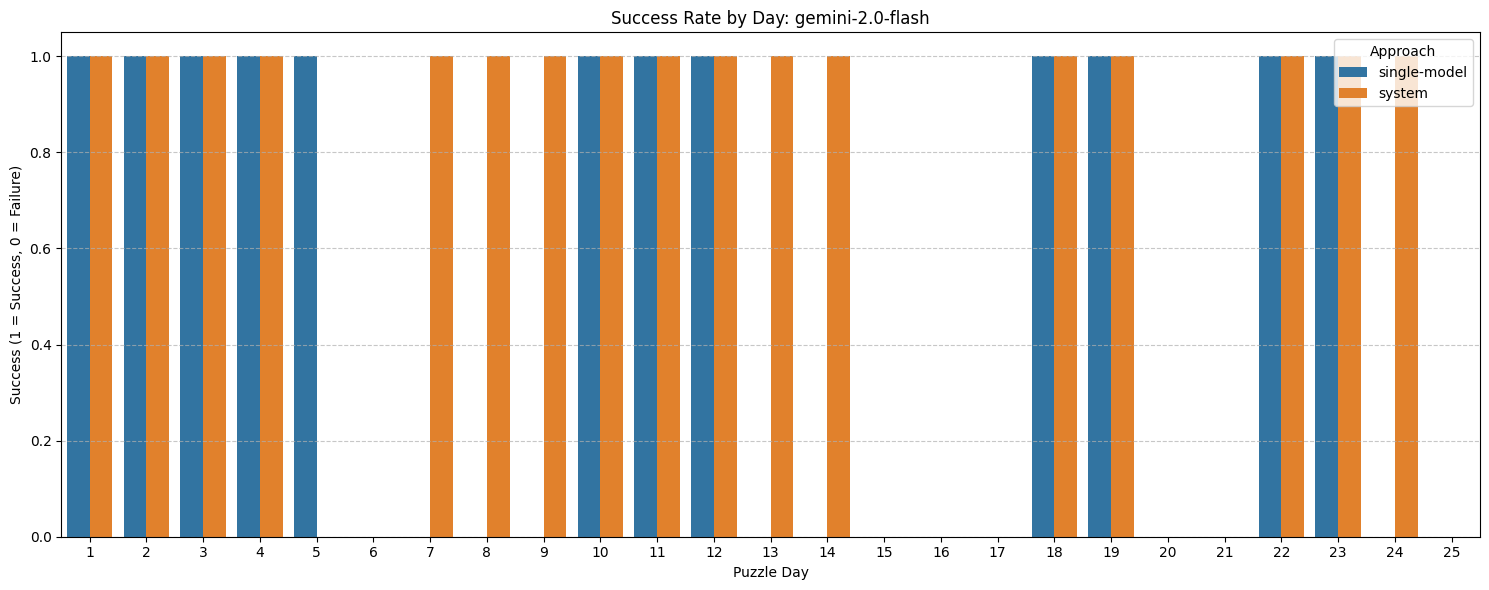

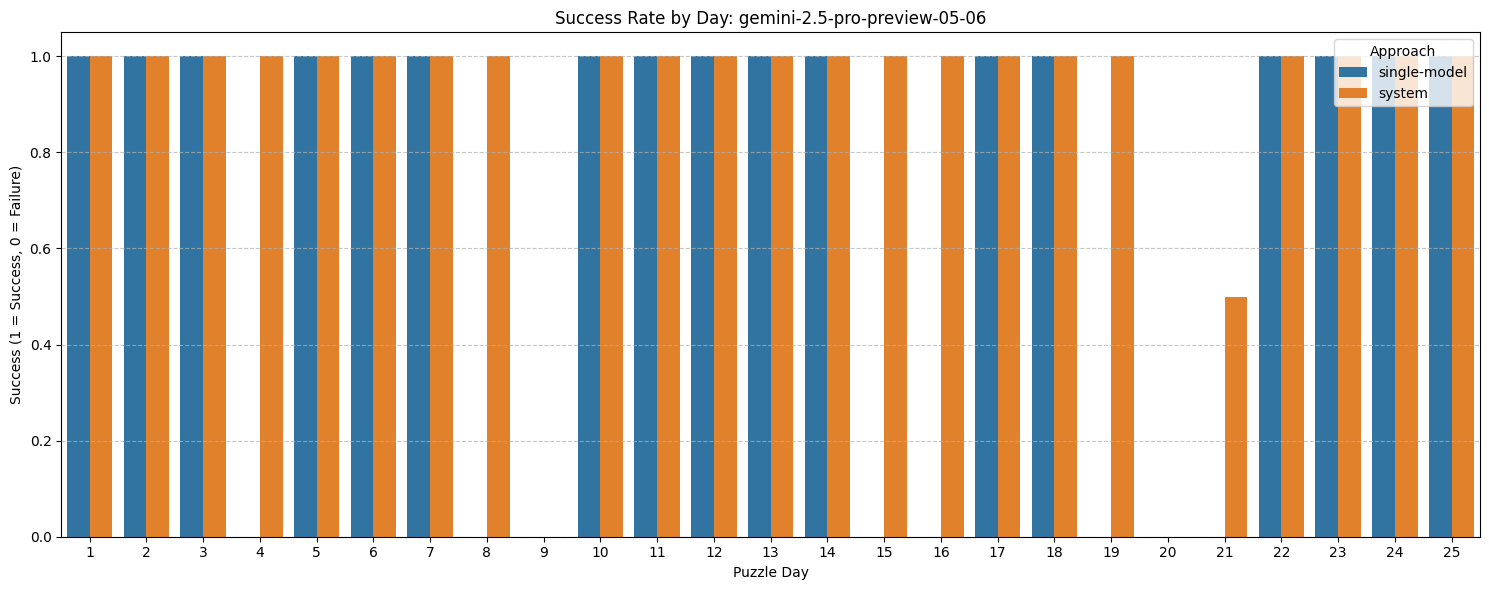

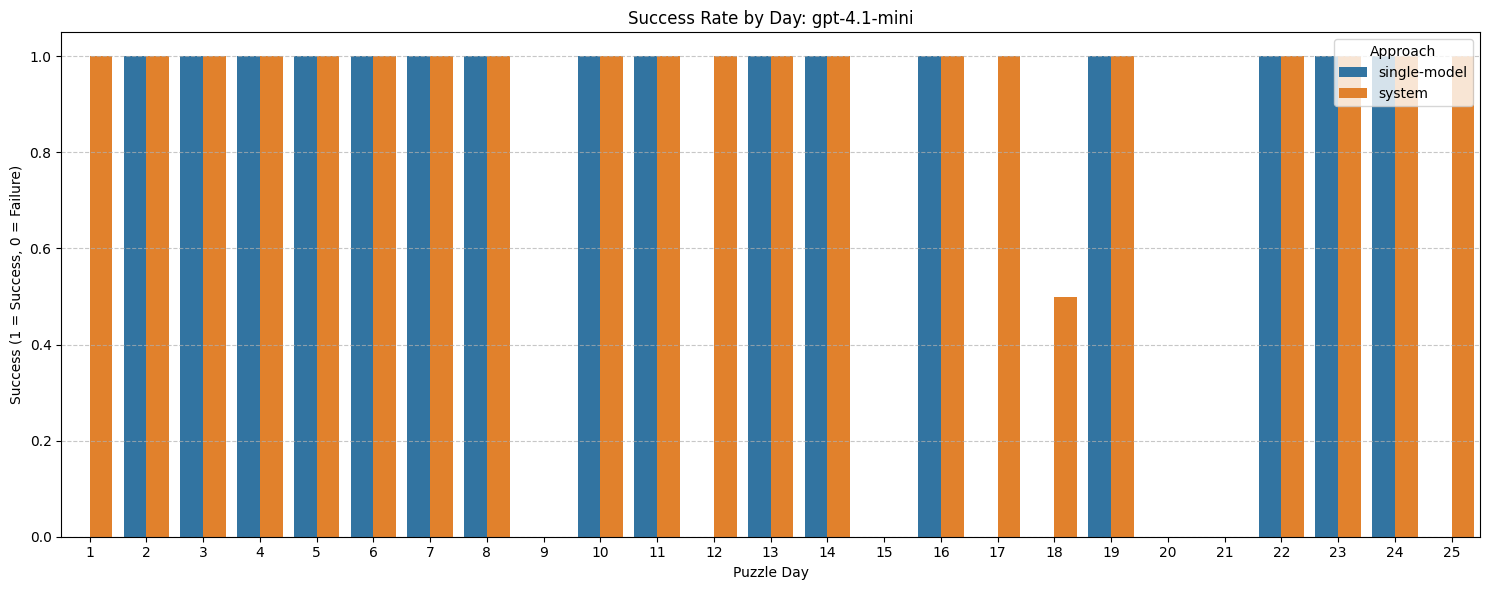

In [60]:
# For each model, create a separate chart
for model_name in df_filtered['model'].unique():
    model_data = df_filtered[df_filtered['model'] == model_name]
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x='day', y='success', hue='approach', data=model_data, errorbar=None)
    plt.title(f'Success Rate by Day: {model_name}')
    plt.xlabel('Puzzle Day')
    plt.ylabel('Success (1 = Success, 0 = Failure)')
    plt.xticks(range(len(model_data['day'].unique())))
    plt.legend(title='Approach')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


#### Time distribution (per model)

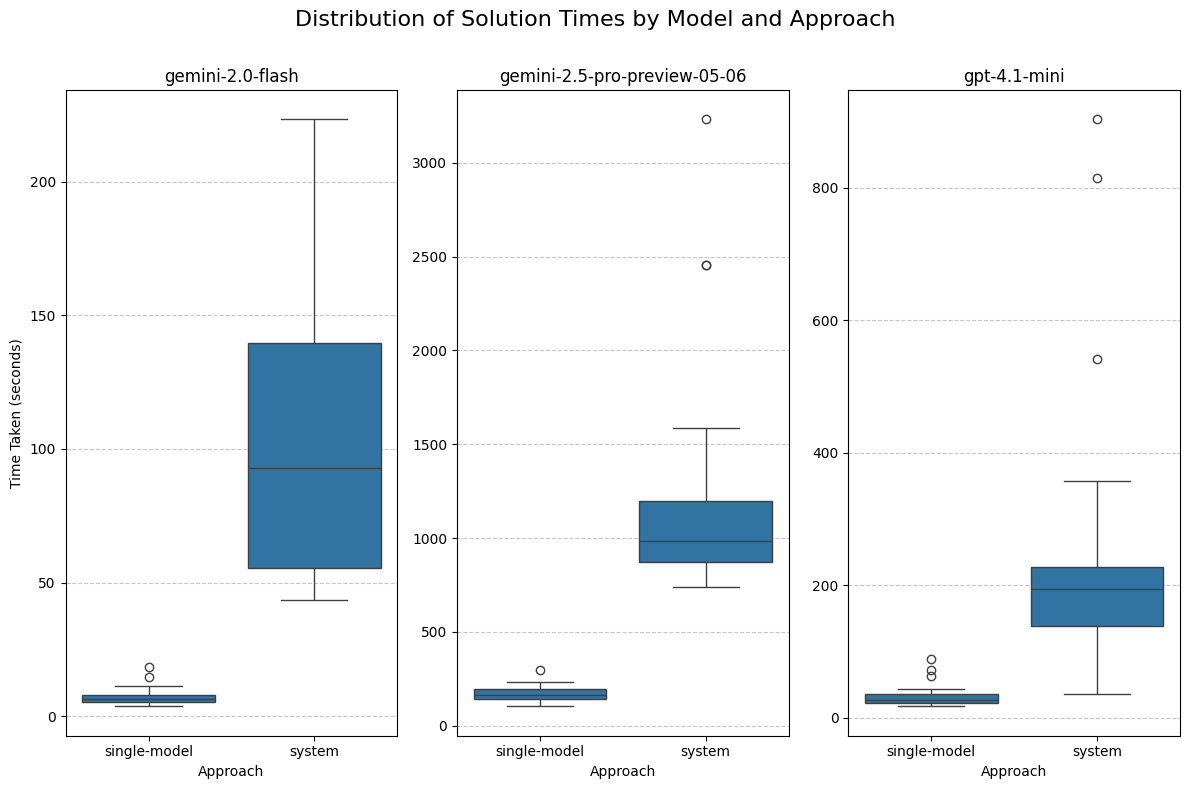

In [61]:
# Create boxplots for each model
plt.figure(figsize=(12, 8))
for i, model_name in enumerate(df_filtered['model'].unique()):
    plt.subplot(1, len(df_filtered['model'].unique()), i+1)
    
    model_data = df_filtered[df_filtered['model'] == model_name]
    sns.boxplot(x='approach', y='time_taken', data=model_data)
    plt.title(f'{model_name}')
    
    if i == 0:  # Only add y-label to the first subplot
        plt.ylabel('Time Taken (seconds)')
    else:
        plt.ylabel('')
    
    plt.xlabel('Approach')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Distribution of Solution Times by Model and Approach', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#### Success Rate VS Time 

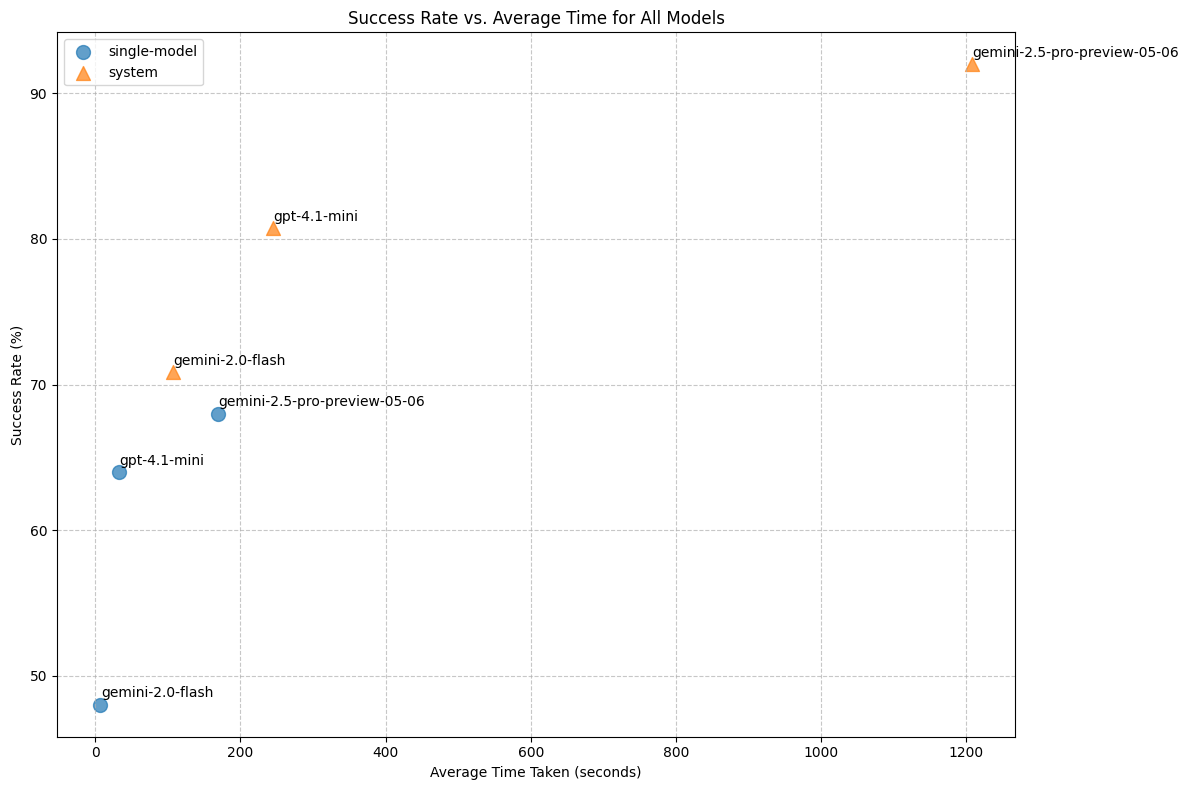

In [62]:
# Calculate success_rate and avg_time for each approach and model
tradeoff_data = df_filtered.groupby(['approach', 'model']).agg(
    success_rate=('success', 'mean'),
    avg_time=('time_taken', 'mean')
).reset_index()

# Convert success_rate to percentage
tradeoff_data['success_rate'] = tradeoff_data['success_rate'] * 100

# Create scatter plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']  # Add more as needed

for i, (approach, group) in enumerate(tradeoff_data.groupby('approach')):
    marker = 'o' if approach == 'single-model' else '^'
    plt.scatter(
        group['avg_time'], 
        group['success_rate'],
        s=100,
        alpha=0.7,
        marker=marker,
        label=f"{approach}",
    )
    
    # Add model name labels for each point
    for _, row in group.iterrows():
        plt.annotate(
            row['model'], 
            (row['avg_time']+0.5, row['success_rate']+0.5)
        )

plt.title('Success Rate vs. Average Time for All Models')
plt.xlabel('Average Time Taken (seconds)')
plt.ylabel('Success Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Model `gemini-2.0-flash`

In [ ]:
# Investigate the results for gemini-2.0-flash
df_gem20_flash = df[df['model'] == 'gemini-2.0-flash']

In [54]:
# 1 day seems to be missing
# Filter for gemini-2.0-flash in the system approach
df_gem_system = df_filtered[(df_filtered['model'] == 'gemini-2.0-flash') & 
                            (df_filtered['approach'] == 'system')]

# Get the days that are present
present_days = set(df_gem_system['day'])

# Expected days (1-25)
all_days = set(range(1, 26))

# Find missing days
missing_days = all_days - present_days
print("Missing days for gemini-2.0-flash in the system approach:", missing_days)


Missing days for gemini-2.0-flash in the system approach: {6}


In [56]:
# Averages
results_per_day = df_gem20_flash.groupby('approach').agg(
    success_rate=('success', 'mean'), 
    avg_time_taken=('time_taken', 'mean')
).reset_index()

results_per_day

,approach,success_rate,avg_time_taken
0,single-model,0.480000,7.388300
1,system,0.708333,107.126905


In [39]:
# Do side by side comparison 
# Reshape the data to include each day
df_comp_gem20_flash = df_gem20_flash.pivot(index='day', columns='approach', values=['success', 'time_taken'])

# Flatten the multi-level column index for easier access
df_comp_gem20_flash.columns = ['_'.join(col).strip() for col in df_comp_gem20_flash.columns.values]

# Reset the index to make 'day' a column
df_comp_gem20_flash = df_comp_gem20_flash.reset_index()
df_comp_gem20_flash

,day,success_single-model,success_system,time_taken_single-model,time_taken_system
0,1,True,True,5.564193,45.201035
1,2,True,True,4.877627,49.976161
2,3,True,True,3.623321,43.277642
3,4,True,True,5.417661,55.734777
4,5,True,False,5.617599,186.303321
5,6,False,NaN,5.775475,NaN
6,7,False,True,4.24254,65.326288
7,8,False,True,6.240673,96.633115
8,9,False,True,11.274895,131.835612
9,10,True,True,6.012236,54.979762


In [40]:
df_comp_gem20_flash['success_comparison'] = df_comp_gem20_flash.apply(
    lambda row: 'Both succeeded' if row['success_single-model'] and row['success_system']
    else 'Single-model only' if row['success_single-model'] and not row['success_system']
    else 'System only' if not row['success_single-model'] and row['success_system']
    else 'Both failed',
    axis=1
)
df_comp_gem20_flash

,day,success_single-model,success_system,time_taken_single-model,time_taken_system,success_comparison
0,1,True,True,5.564193,45.201035,Both succeeded
1,2,True,True,4.877627,49.976161,Both succeeded
2,3,True,True,3.623321,43.277642,Both succeeded
3,4,True,True,5.417661,55.734777,Both succeeded
4,5,True,False,5.617599,186.303321,Single-model only
5,6,False,NaN,5.775475,NaN,System only
6,7,False,True,4.24254,65.326288,System only
7,8,False,True,6.240673,96.633115,System only
8,9,False,True,11.274895,131.835612,System only
9,10,True,True,6.012236,54.979762,Both succeeded


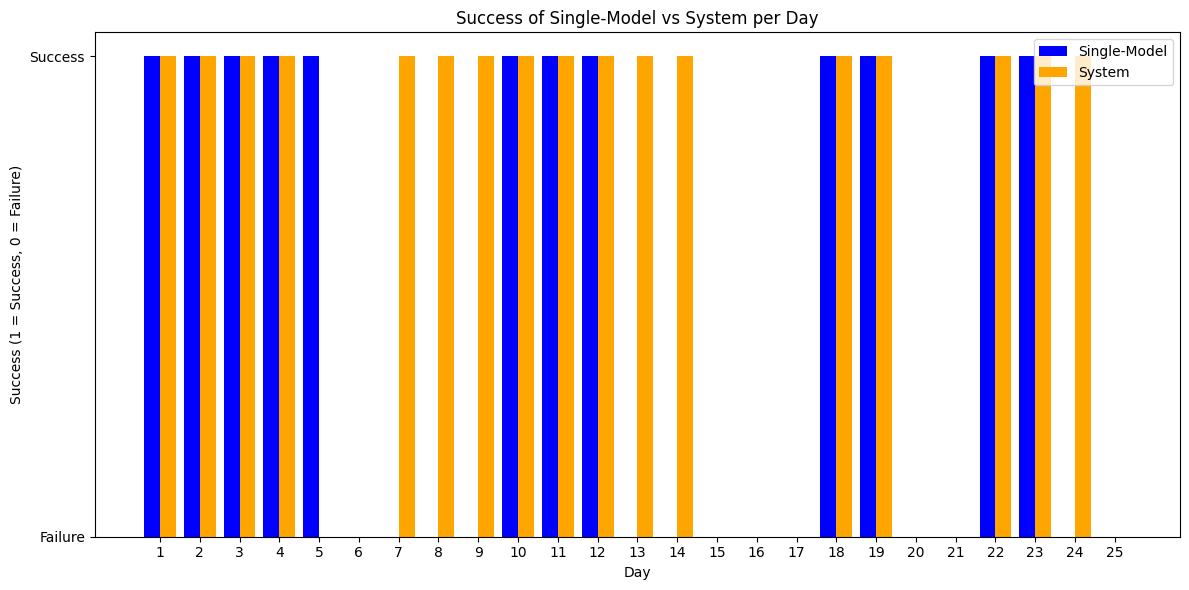

In [42]:
# Prepare the data
days = df_comp_gem20_flash['day']
success_single_model = df_comp_gem20_flash['success_single-model']
success_system = df_comp_gem20_flash['success_system']

# Set the width of the bars
bar_width = 0.4

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(days - bar_width / 2, success_single_model, width=bar_width, label='Single-Model', color='blue')
plt.bar(days + bar_width / 2, success_system, width=bar_width, label='System', color='orange')

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Success (1 = Success, 0 = Failure)')
plt.title('Success of Single-Model vs System per Day')
plt.xticks(days)  # Use the 'day' column directly for x-axis ticks
plt.yticks([0, 1], ['Failure', 'Success'])  # Label the y-axis as Failure/Success
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


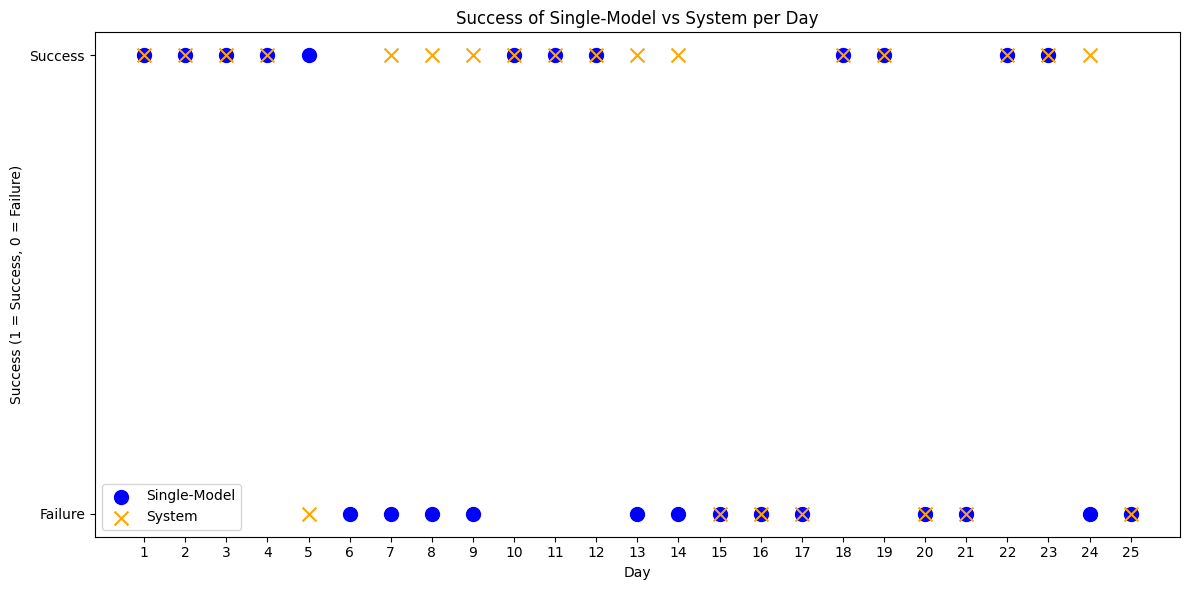

In [43]:
# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(days, success_single_model, label='Single-Model', color='blue', marker='o', s=100)
plt.scatter(days, success_system, label='System', color='orange', marker='x', s=100)

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Success (1 = Success, 0 = Failure)')
plt.title('Success of Single-Model vs System per Day')
plt.xticks(days)  # Use the 'day' column directly for x-axis ticks
plt.yticks([0, 1], ['Failure', 'Success'])  # Label the y-axis as Failure/Success
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [45]:
# Create a table showing success for both approaches
success_table = df_comp_gem20_flash[['day', 'success_single-model', 'success_system']]

# Add a column to compare success (e.g., both succeeded, one failed, etc.)
success_table['success_comparison'] = success_table.apply(
    lambda row: 'Both succeeded' if row['success_single-model'] and row['success_system']
    else 'Single-model only' if row['success_single-model'] and not row['success_system']
    else 'System only' if not row['success_single-model'] and row['success_system']
    else 'Both failed',
    axis=1
)

success_table

/tmp/ipykernel_27278/877376504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_table['success_comparison'] = success_table.apply(


,day,success_single-model,success_system,success_comparison
0,1,True,True,Both succeeded
1,2,True,True,Both succeeded
2,3,True,True,Both succeeded
3,4,True,True,Both succeeded
4,5,True,False,Single-model only
5,6,False,NaN,System only
6,7,False,True,System only
7,8,False,True,System only
8,9,False,True,System only
9,10,True,True,Both succeeded
